## Import Modules

In [1]:
import os
import pickle
import glob
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image

from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = 'C:/Users/Ivan Munandar/Downloads/PA Orbit/Dataset/Flickr8k_Dataset'
WORKING_DIR = 'C:/Users/Ivan Munandar/Downloads/PA Orbit/File Program/Fix'


## Data Understanding and Visualization


In [3]:
images_dir ='C:/Users/Ivan Munandar/Downloads/PA Orbit/Dataset/Flickr8k_Dataset/Images'
all_imgs = glob.glob(images_dir + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


C:\ProgramData\Anaconda3\envs\orbit-env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


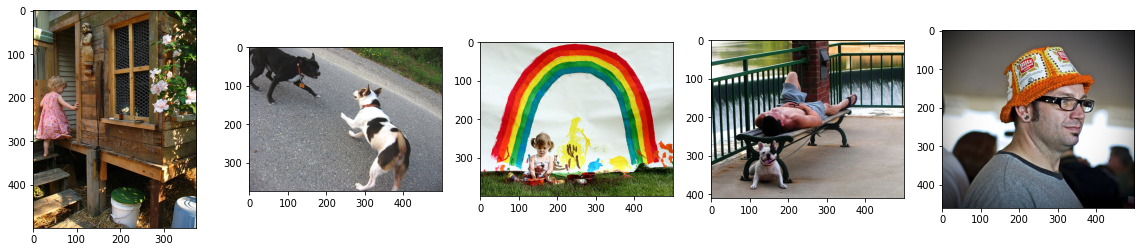

In [4]:
import imageio
#Visualising first 5 images :
Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)

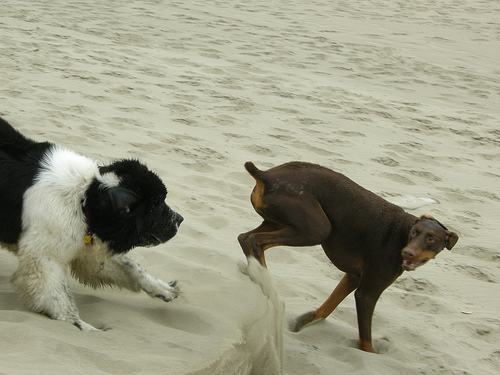

In [5]:
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])# view a random image
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])

In [6]:
text_file = 'C:/Users/Ivan Munandar/Downloads/PA Orbit/Dataset/Flickr8k_Dataset/captions.txt'
def load_doc(filename):
    open_file = open(text_file, 'r', encoding='latin-1' ) 
    text = open_file.read() 
    open_file.close()
    return text
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [7]:
img_path = 'C:/Users/Ivan Munandar/Downloads/PA Orbit/Dataset/Flickr8k_Dataset/Images/'

all_img_id = [] 
all_img_vector = [] 
annotations = [] 

with open('C:/Users/Ivan Munandar/Downloads/PA Orbit/Dataset/Flickr8k_Dataset/captions.txt' , 'r') as fo:
  next(fo) 
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,C:/Users/Ivan Munandar/Downloads/PA Orbit/Data...,A rock climber in a red shirt


In [8]:
#check total captions and images present in dataset
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [9]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary) 
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

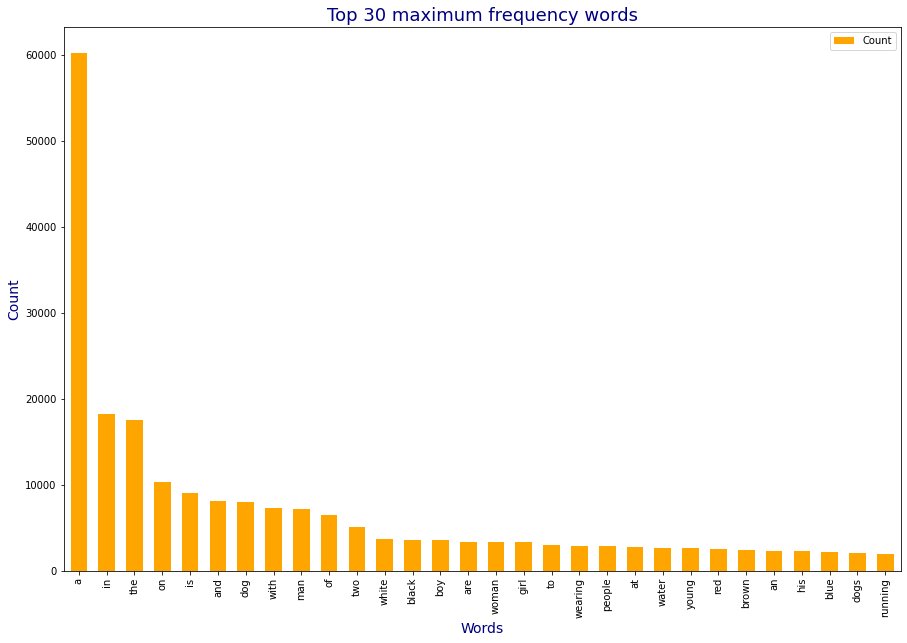

In [10]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
  print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='orange', figsize=(15, 10))
plt.title("Top 30 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')

## Extract Image Features

In [11]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [13]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [14]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [15]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [16]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [17]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [18]:
len(mapping)

8091

## Preprocess Text Data

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
# preprocess the text
clean(mapping)

In [22]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [24]:
len(all_captions)

40455

In [25]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [26]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))
vocab_size = len(tokenizer.word_index) + 1

In [27]:
vocab_size

8485

In [28]:
# Creating a word count for our tokenizer to visualize the Top 30 occuring words after text processing

tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)

a :  38716
A :  21480
in :  18170
the :  14587
on :  10354
is :  9069
and :  8057
dog :  7804
with :  7303
man :  6727
of :  6495
Two :  3962
white :  3646
black :  3491
boy :  3395
are :  3364
girl :  3174
woman :  3146
to :  3005
The :  2919
wearing :  2916
at :  2809
water :  2671
red :  2542
young :  2411
people :  2397
brown :  2383
his :  2255
blue :  2116
dogs :  2055


C:\ProgramData\Anaconda3\envs\orbit-env\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  if sys.path[0] == '':


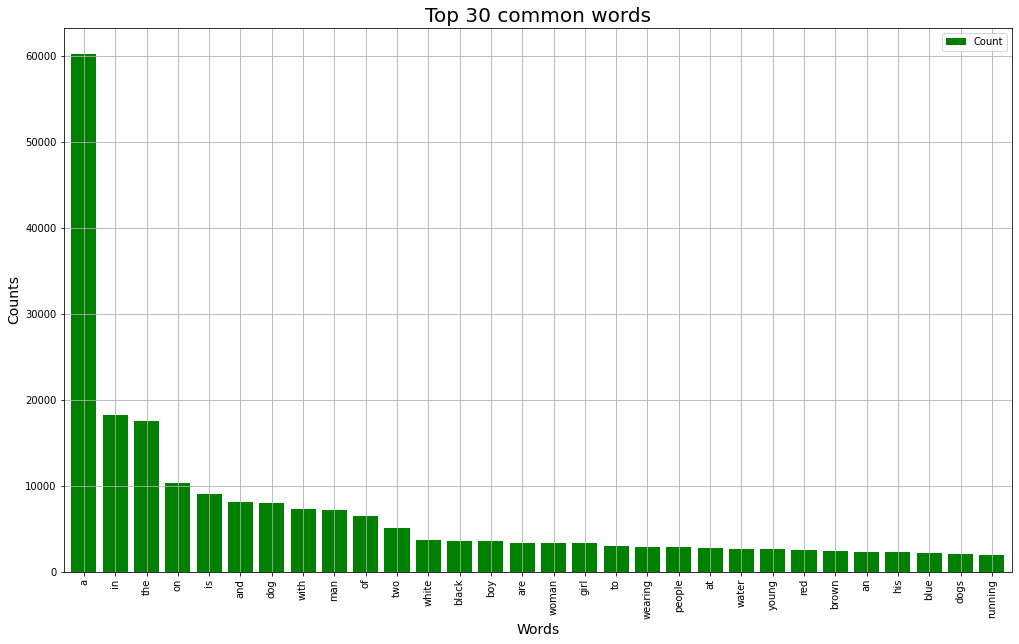

In [29]:
for word, count in tokenizer_top_words_count.most_common(30) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, color = 'green', figsize = (17, 10))
plt.title('Top 30 common words', fontsize =20, color= 'black')
plt.xlabel('Words', fontsize =14, color= 'black')
plt.ylabel('Counts', fontsize =14, color= 'black')
plt.grid(b=None)

In [30]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Spliting Dataset

In [31]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [32]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [33]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

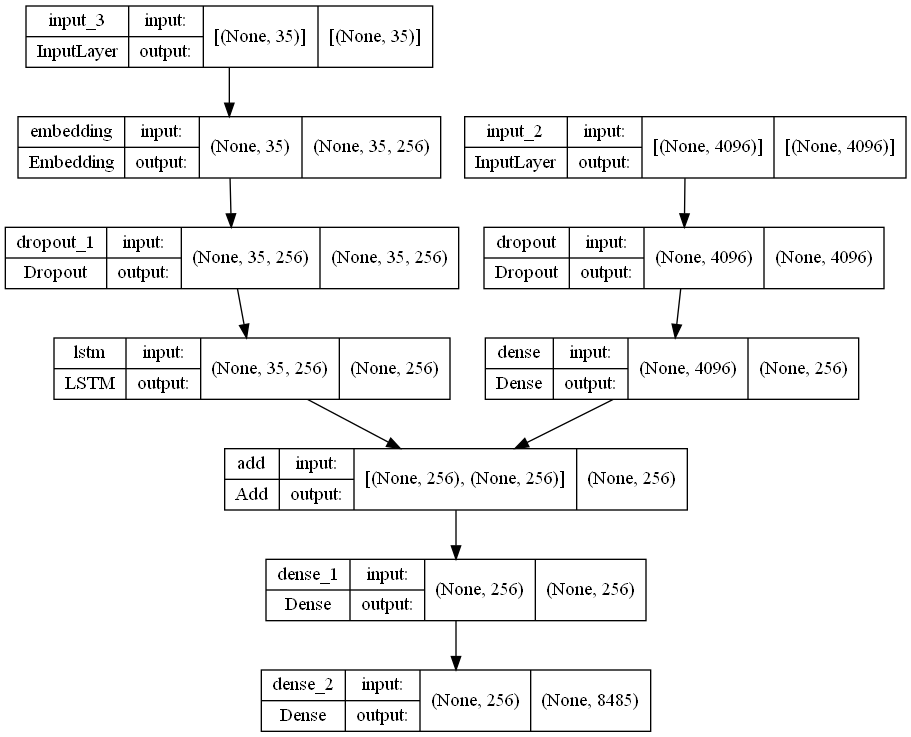

In [34]:
# plot the model
plot_model(model, to_file='model.png', show_shapes=True)

In [37]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

# create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit for one epoch
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
227/227 [==============================] - 68s 284ms/step - loss: 3.7101e-04 - accuracy: 0.4637
Epoch 2/30
227/227 [==============================] - 66s 290ms/step - loss: 3.5441e-04 - accuracy: 0.4719
Epoch 3/30
227/227 [==============================] - 67s 295ms/step - loss: 3.4793e-04 - accuracy: 0.4773
Epoch 4/30
227/227 [==============================] - 67s 294ms/step - loss: 3.4391e-04 - accuracy: 0.4806
Epoch 5/30
227/227 [==============================] - 67s 294ms/step - loss: 3.4102e-04 - accuracy: 0.4827
Epoch 6/30
227/227 [==============================] - 67s 295ms/step - loss: 3.3877e-04 - accuracy: 0.4840
Epoch 7/30
227/227 [==============================] - 68s 298ms/step - loss: 3.3674e-04 - accuracy: 0.4875
Epoch 8/30
227/227 [==============================] - 67s 296ms/step - loss: 3.3489e-04 - accuracy: 0.4889
Epoch 9/30
227/227 [==============================] - 67s 296ms/step - loss: 3.3311e-04 - accuracy: 0.4908
Epoch 10/30
227/227 [================

In [38]:
# save the model
model.save(WORKING_DIR+'/model.h5')

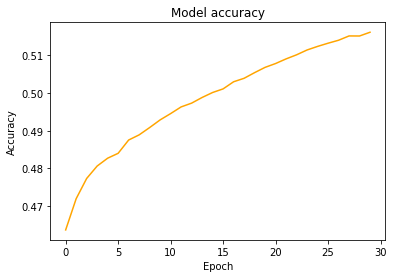

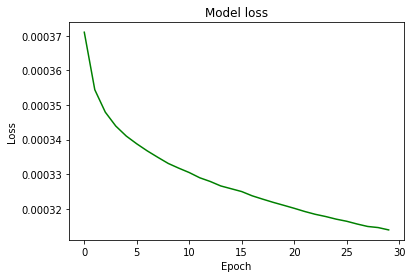

In [39]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'], color='orange')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'], color='green')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Generate Captions for the Image

In [40]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [41]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text



## Evaluation


In [42]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.544592
BLEU-2: 0.320093
BLEU-3: 0.237038
BLEU-4: 0.124686


## Visualize the Results

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the sidewalk endseq


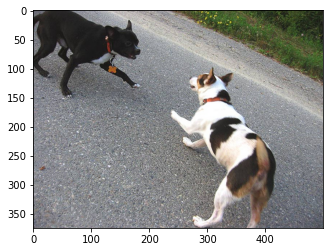

In [44]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq girl in pink dress is sitting in front of rainbow tree endseq


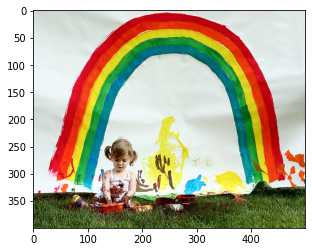

In [45]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man in skis on skis endseq


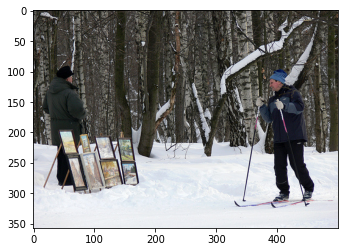

In [46]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man in red jacket is sitting on bench whilst cooking meal endseq
startseq "a man is sitting on bench cooking some food ." endseq
startseq man sits on bench endseq
startseq man wearing red jacket is sitting on wooden bench and is cooking something in small pot endseq
startseq man wearing red jacket sitting on bench next to various camping items endseq
--------------------Predicted--------------------
startseq man in red jacket is standing on bench endseq


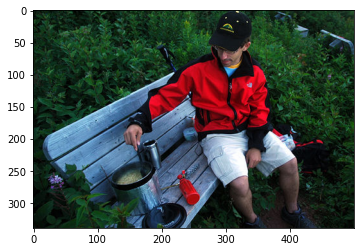

In [47]:
generate_caption("35506150_cbdb630f4f.jpg")

---------------------Actual---------------------
startseq man holds long leash with large gray dog attached to it endseq
startseq man is holding very long leash attached to very large dog who is smelling the grass endseq
startseq man is walking grey dog on the grass using long leash endseq
startseq man walks black dog on very long leash endseq
startseq woman and dog are in field of bright green grass and brilliant blue sky endseq
--------------------Predicted--------------------
startseq man is walking through field of grass using large leash endseq


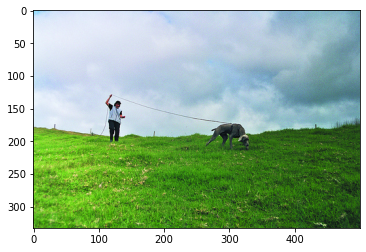

In [48]:
generate_caption("411863595_d77156687e.jpg")